# Evaluation of Relationship Annotation Accuracy Based on a QC'd Sample

This notebook covers the evaluation of user annotations in comparison of the randomly sampled set of completed tasks that have been manually annotated.  

## Import modules and load data

In [1]:
import pandas
import m2c_rel_basic
import relationship_dictionaries
import random
import matplotlib
from matplotlib import pyplot as mplot
from pandas import read_csv

Import the relationship annotations data for only completed concept pairs

In [2]:
savepath = 'data/'
exppath = 'results/'
all_completed_anns = read_csv(exppath+'all_completed_anns.txt', delimiter='\t', header=0)
all_completed_anns.drop("Unnamed: 0",axis=1,inplace=True)

Import the Quality Curated Sample Annotations

In [3]:
esample_df = m2c_rel_basic.get_QC_data(savepath)

Import the dictionaries for translating hashed responses

In [4]:
rel_hash_dict,redundant_response_dict,abbreviated_rels_dict,abbreviated_rels_dict_4_hash,concept_broken_dict,concept_not_broken_dict = relationship_dictionaries.load_RE_dictionaries()

## Analyze the user annotations relative to the quality curated annotations

pull the annotations marked 'broken' during QC'ing into a set

In [5]:
expert_broken = esample_df.loc[esample_df['conclusion']=='concept_broken']

pull the cpmids (concept pair pmid hashed identifiers) that were QC'd into a set

In [6]:
expert_cpmids = set(esample_df['cpmid'].tolist())

Get the cpmids from the set of annotations that were QC'd and use the cpmids from the QC'd set to pull all user annotations for the same cpmids

In [7]:
test_set_cpmids = set(expert_cpmids)
total_ref_set = all_completed_anns.loc[all_completed_anns['cpmid'].isin(test_set_cpmids)].copy()

Abbreviate the user responses for ease of viewing

In [8]:
total_ref_set['evtype'].replace(abbreviated_rels_dict_4_hash, inplace=True)

Remove distinction between C1 broken and C2 broken since it's technically possible for both to be true AND because it's not important to distinguish it in this analysis

In [9]:
total_ref_set['evtype'].replace(concept_broken_dict, inplace=True)
esample_df['conclusion'].replace(concept_broken_dict, inplace=True)
print(total_ref_set.head(2))

   kind             ann_date  user_id         evtype reltype      pmid  \
8    re  2016-05-24 06:54:49      364  g_unrelated_d     g_d  11353896   
14   re  2016-05-24 07:23:43      364   g_mutation_d     g_d  16970037   

        concept_created      concept_updated refid1   refid2    concept_pair  \
8   2015-05-21 17:54:48  2015-05-21 17:54:48   4158  D004931  4158_x_D004931   
14  2015-05-21 17:54:44  2015-05-21 17:54:44   8086  D009461  8086_x_D009461   

   refid1_type refid2_type  user_count  relation_count  test_completions  \
8            g           d        29.0            14.0               1.0   
14           g           d        27.0            19.0               3.0   

    true_responses  response_ratio                    cpmid  
8             28.0        0.500000  11353896_4158_x_D004931  
14            24.0        0.791667  16970037_8086_x_D009461  


### Randomly subsample the user annotations to determine how voting threshold (k) relates to agreement with the quality-checked results.

Sample the responses and put the results into a dataframe, 10 iterations per k per cpmid. repeat the sampling 5 times to stabilize the results

Note that this is the slowest part of the notebook; hence, a print statement has been left in so you know it's working

In [11]:

k=1
majority_response=[]
j=0

while j<5:
    i=0
    print('repetition:',j)
    while i<10:
        k=1
        while k<16:
            for each_cpmid in test_set_cpmids:
                result_dict = {}
                result_dict['repetition'] = j
                result_dict['iteration'] = i
                result_dict['cpmid'] = each_cpmid
                result_dict['k'] = k
                tmp_df = total_ref_set.loc[total_ref_set['cpmid']==each_cpmid]
                user_set = set(tmp_df['user_id'].tolist())
                if k<=len(user_set):
                    user_sample = random.sample(user_set, k)
                    ref_sample = tmp_df.loc[tmp_df['user_id'].isin(user_sample)]
                    if k == 1:
                        result_dict['response'] = ref_sample.iloc[0]['evtype']
                        result_dict['majority?'] = 'yes'
                        result_dict['tie?'] = 'no'
                        result_dict['result_selection'] = 'single_vote'
                    else:
                        ## Groupby response and get biggest and next biggest value    
                        ref_sample_size = ref_sample.groupby(['cpmid','evtype']).size().reset_index(name='counts')
                        ref_sample_size.sort_values('counts', ascending=False, inplace=True)
                        first_most = ref_sample_size.iloc[0]['counts']
                        try:
                            sec_most = ref_sample_size.iloc[1]['counts'] ##if this works, results are not unanimous
                            if first_most > sec_most: ## If there is a majority
                                result_dict['majority?'] = 'simple_majority'
                                result_dict['result_selection'] = 'majority'
                                result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                                result_dict['tie?'] = 'no'
                            else: ## else it's a tie
                                result_dict['majority?'] = 'no_majority'
                                result_dict['result_selection'] = 'random'
                                if len(ref_sample_size)==2: ## check if full tie
                                    rand_option = random.randint(0, 1)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'two_way'
                                elif (len(ref_sample_size) > 2) & (sec_most > ref_sample_size.iloc[3]['counts']): #check if majority tied
                                    rand_option = random.randint(0, 1)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'top_two_way'
                                elif (len(ref_sample_size) > 2) & (sec_most == ref_sample_size.iloc[3]['counts']): #check for 3-way tie                      
                                    rand_option = random.randint(0, 2)
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = '3_way'
                                else:    
                                    rand_option = random.randint(0, len(ref_sample_size))
                                    result_dict['response'] = ref_sample_size.iloc[rand_option]['evtype']
                                    result_dict['tie?'] = 'other'
                        except: ## Scenario: results are unanimous
                            result_dict['majority?'] = 'unanimous'
                            result_dict['response'] = ref_sample_size.iloc[0]['evtype']
                            result_dict['tie?'] = 'no'
                            result_dict['result_selection'] = 'majority'
                else:
                    result_dict['majority?'] = 'n/a'
                    result_dict['response'] = 'not_enough'
                    result_dict['tie?'] = 'n/a'
                    result_dict['result_selection'] = 'n/a' 
                ## check how well user response matched expert response
                tmp_edf = esample_df.loc[esample_df['cpmid']==each_cpmid]           
                test_response = result_dict.get('response')
                expert_response = tmp_edf['conclusion'].iloc[0]
                if test_response=='not_enough':
                    result_dict['expert_match?'] = 'n/a'
                elif test_response == expert_response:
                    result_dict['expert_match?'] = 'yes'
                else:
                    result_dict['expert_match?'] = 'no'
                majority_response.append(result_dict) 
            k = k+1
        i=i+1
    j=j+1
    

majority_df = pandas.DataFrame(majority_response)

print(majority_df.head(5))

repetition: 0
repetition: 1
repetition: 2
repetition: 3
repetition: 4
                        cpmid expert_match?  iteration  k majority?  \
0   8006362_D005227_x_D000326           yes          0  1       yes   
1     16970037_8086_x_D009422           yes          0  1       yes   
2  12882516_C097320_x_D000544            no          0  1       yes   
3     21626165_8086_x_D012021            no          0  1       yes   
4     16938764_8086_x_D004931           yes          0  1       yes   

   repetition        response result_selection tie?  
0           0  concept_broken      single_vote   no  
1           0    g_mutation_d      single_vote   no  
2           0     c_related_d      single_vote   no  
3           0   g_unrelated_d      single_vote   no  
4           0    g_mutation_d      single_vote   no  


### Aggregate the resulting data, grouping by iteration and threshold

Count number of expert_match (true positive) vs total number of responses (true positive plus incorrect response) 
This gives total number of answers that matched vs didn't match the QC'd result for the whole QC cpmid set at every level of k, for each repetition and iteration

In [12]:
response_matrix = majority_df.groupby(['repetition','iteration','k','expert_match?']).size().reset_index(name='counts')

remove the n/a responses (this is usually when k exceeds sample due to removal of tester account data)

In [13]:
response_matrix_less_missing = response_matrix.loc[response_matrix['expert_match?']!='n/a']
total_captured = response_matrix_less_missing.groupby(['repetition','iteration','k'])['counts'].sum().reset_index(name='totals')


Merge tables to be able to do calculations and obtain total attempts, then calculate accuracy (True Positive/Total) and inaccuracy (Incorrect Response/Total)

In [14]:
tmpresults_df = response_matrix.merge(total_captured,on=(['repetition','iteration','k']))
tmpresults_df['ratios'] = tmpresults_df['counts']/tmpresults_df['totals']
#print(tmpresults_df)

Since accuracy only counts true positives and total attempts, keep only the true positive data and Calculate the mean, max, median, and sem of the accuracy data frame by aggregating over the 10 iterations

In [15]:
accuracy_df = tmpresults_df.loc[tmpresults_df['expert_match?']=='yes']

mean_accuracy = accuracy_df.groupby(['repetition','k']).ratios.mean().reset_index(name='avg_accuracy')
max_accuracy = accuracy_df.groupby(['repetition','k']).ratios.max().reset_index(name='max_accuracy')
median_accuracy = accuracy_df.groupby(['repetition','k']).ratios.median().reset_index(name='median_accuracy')
mean_error = accuracy_df.groupby(['repetition','k']).ratios.sem().reset_index(name='std_error')
    
stats_result = mean_accuracy.merge(max_accuracy.merge(median_accuracy.merge(mean_error, on=(['repetition','k']), how='left'), on=(['repetition','k']), how='left'), on=(['repetition','k']), how='left')
print(stats_result.head(n=2))

   repetition  k  avg_accuracy  max_accuracy  median_accuracy  std_error
0           0  1      0.637069      0.698276         0.637931   0.011088
1           0  2      0.644828      0.681034         0.659483   0.010813


Since max_accuracy is not any sort of average and can vary greatly, aggregate across the 5 repetitions and calculate mean, median, max of the mean accuracy

In [16]:
mean_accuracy = stats_result.groupby('k').avg_accuracy.mean().reset_index(name='mean_avg_accuracy')
max_accuracy = stats_result.groupby('k').max_accuracy.mean().reset_index(name='mean_max_accuracy')
median_accuracy = stats_result.groupby('k').median_accuracy.mean().reset_index(name='mean_median_accuracy')

## aggregate across the 5 repetitions and calculate standard error for mean, max, and median accuracy
mean_error1 = stats_result.groupby('k').avg_accuracy.sem().reset_index(name='mean_std_error')
mean_error2 = stats_result.groupby('k').max_accuracy.sem().reset_index(name='mean_max_std_error')
mean_error3 = stats_result.groupby('k').median_accuracy.sem().reset_index(name='mean_median_std_error')

mean_error =  mean_error1.merge(mean_error2.merge(mean_error3, on='k', how='left'), on='k', how='left')
   
stats_result2 = mean_accuracy.merge(max_accuracy.merge(median_accuracy.merge(mean_error, on='k', how='left'), on='k', how='left'), on='k', how='left')
print(stats_result2.head(n=2))


   k  mean_avg_accuracy  mean_max_accuracy  mean_median_accuracy  \
0  1           0.635517           0.698276              0.634483   
1  2           0.642069           0.689655              0.643966   

   mean_std_error  mean_max_std_error  mean_median_std_error  
0        0.002759            0.007711               0.003708  
1        0.002606            0.007711               0.005553  


In [18]:
### Export results
stats_result2.to_csv(exppath+"fig1c_data.txt", sep='\t', header=True)

### Visualize the results

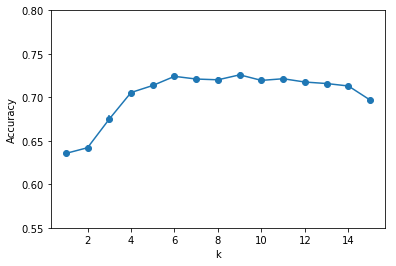

In [19]:
plot_it = stats_result2[['mean_avg_accuracy','k','mean_std_error']].copy()
mplot.figure()
mplot.xlabel("k")
mplot.ylabel("Accuracy")
mplot.ylim(0.55, 0.80)
mplot.errorbar(x='k',y='mean_avg_accuracy', yerr='mean_std_error', data=plot_it, linestyle='-', marker='o')
mplot.title("Voter threshold vs accuracy")
mplot.show()
#mplot.savefig(exppath+'votingthresh_accuracy.png', bbox_inches='tight', dpi=300)